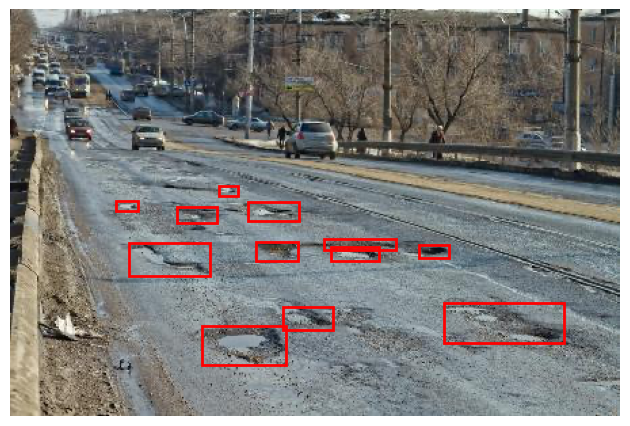

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import xmltodict

# Load the image
image_path = "/dtu/datasets1/02516/potholes/images/potholes0.png"
img = mpimg.imread(image_path)

# Load and parse the XML file
xml_path = "/dtu/datasets1/02516/potholes/annotations/potholes0.xml"
with open(xml_path) as file:
    file_data = file.read() # read file contents

    # parse data using package
    dict_data = xmltodict.parse(file_data)

# Extract bounding box coordinates
list_with_all_boxes = []
for obj in dict_data['annotation']['object']:
        ymin = int(obj['bndbox']['ymin'])
        xmin = int(obj['bndbox']['xmin'])
        ymax = int(obj['bndbox']['ymax'])
        xmax = int(obj['bndbox']['xmax'])

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

# Plot the image
plt.imshow(img)

# Add bounding boxes to the image
for box in list_with_all_boxes:
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height, edgecolor='red', facecolor='none', linewidth=2)
    plt.gca().add_patch(rect)

plt.axis("off")
plt.tight_layout()
plt.show()

Found 665 images.


Processing images:   0%|          | 0/665 [00:00<?, ?it/s]

Processing /dtu/datasets1/02516/potholes/images/potholes0.png...
Original shape: (300, 450, 3)
Found 1160 proposals.


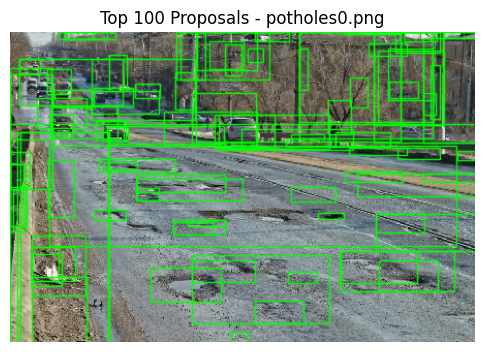

Processing images: 100%|██████████| 665/665 [12:03<00:00,  1.09s/it]

Processed 665 images.


In [7]:
import cv2
import glob
import os
from tqdm import tqdm

# Path to images
image_dir = "/dtu/datasets1/02516/potholes/images/"
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))

print(f"Found {len(image_paths)} images.")

def run_selective_search(image, method='fast'):
    # Create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    
    # Set the image on which we will run segmentation
    ss.setBaseImage(image)
    
    # Switch to fast but low recall Selective Search method
    if method == 'fast':
        ss.switchToSelectiveSearchFast()
    # Switch to high recall but slow Selective Search method
    elif method == 'quality':
        ss.switchToSelectiveSearchQuality()
        
    # Run selective search segmentation on input image
    rects = ss.process()
    return rects

# Dictionary to store proposals for all images
all_proposals = {}

# Loop through all images
for i, img_path in tqdm(enumerate(image_paths), total=len(image_paths), desc="Processing images"):
    img = cv2.imread(img_path)
    if img is None:
        continue

    # Run Selective Search
    rects = run_selective_search(img, method='fast')

    # Store proposals (rescaling back to original size)
    rects_original = []
    for (x, y, w, h) in rects:
        rects_original.append([int(x), int(y), int(w), int(h)])
        
    all_proposals[os.path.basename(img_path)] = rects_original
    
    if i == 0: # Visualize the first one
        print(f"Processing {img_path}...")
        print(f"Original shape: {img.shape}")
        print(f"Found {len(rects)} proposals.")
        
        imOut = img.copy()
        # Draw top 100 proposals
        for j, (x, y, w, h) in enumerate(rects):
            if j < 100:
                cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(imOut, cv2.COLOR_BGR2RGB))
        plt.title(f"Top 100 Proposals - {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()

print(f"Processed {len(all_proposals)} images.")